--- Sentiment Counts (Combined) ---
Positive reviews: 28566
Negative reviews: 4192
Neutral reviews: 17112
------------------------------


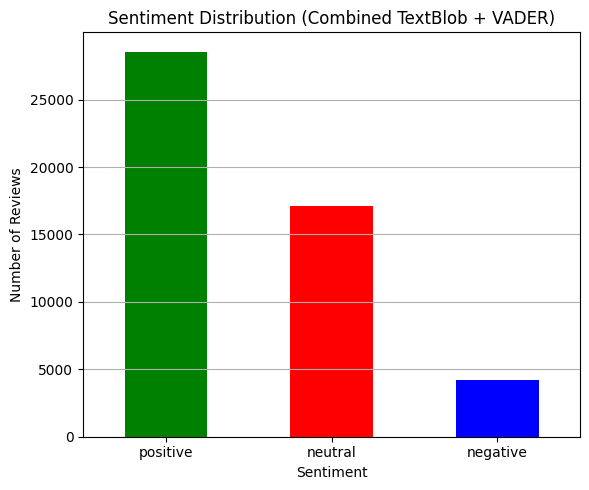

Saved as 'clean_sample.csv'
49870 records inserted into MongoDB.


In [1]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 2. OPTIONAL: Activate MongoDB insertion
USE_MONGODB = True

# 3. Load the dataset
df = pd.read_csv("dataset.csv", nrows=50000)

# 4. Remove rows where 'review_text' is missing
df = df.dropna(subset=["review_text"])
df["review_text"] = df["review_text"].astype(str).str.lower()


# --- Sentiment Analysis with TextBlob ---
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.polarity > 0:
        return "positive"
    elif analysis.polarity < 0:
        return "negative"
    else:
        return "neutral"


df["sentiment_label_textblob"] = df["review_text"].apply(get_textblob_sentiment)

# --- Sentiment Analysis with VADER ---
analyzer = SentimentIntensityAnalyzer()


def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text)
    if vs["compound"] >= 0.05:
        return "positive"
    elif vs["compound"] <= -0.05:
        return "negative"
    else:
        return "neutral"


df["sentiment_label_vader"] = df["review_text"].apply(get_vader_sentiment)


# --- Combine TextBlob and VADER sentiment ---
def combine_sentiments(row):
    tb = row["sentiment_label_textblob"]
    vd = row["sentiment_label_vader"]
    if tb == vd:
        return tb
    else:
        return "neutral"


df["sentiment_combined"] = df.apply(combine_sentiments, axis=1)

# --- Drop original score-based sentiment columns if they exist ---
df = df.drop(
    columns=[
        col for col in ["review_score", "sentiment_label_score"] if col in df.columns
    ]
)

# 7. Count and print the number of positive and negative reviews
print("--- Sentiment Counts (Combined) ---")
print(f"Positive reviews: {(df['sentiment_combined'] == 'positive').sum()}")
print(f"Negative reviews: {(df['sentiment_combined'] == 'negative').sum()}")
print(f"Neutral reviews: {(df['sentiment_combined'] == 'neutral').sum()}")
print("-" * 30)

# 8. Plot sentiment distribution for combined method
plt.figure(figsize=(6, 5))
df["sentiment_combined"].value_counts().plot(kind="bar", color=["green", "red", "blue"])
plt.title("Sentiment Distribution (Combined TextBlob + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# 9. Save the cleaned and labeled dataset
df.to_csv("clean_sample.csv", index=False)
print("Saved as 'clean_sample.csv'")

# 10. Optional: Insert into MongoDB
if USE_MONGODB:
    from pymongo import MongoClient

    client = MongoClient("mongodb://localhost:27017/")
    db = client["steam_reviews_nlp"]
    collection = db["cleaned_reviews_nlp"]
    records = df.to_dict(orient="records")
    collection.insert_many(records)
    print(f"{len(records)} records inserted into MongoDB.")